## Habitat and Distribution of Cetacea: Happy Whales Dataset


<div class="alert alert-block alert-info">

<strong><a href="https://happywhale.com/home">HappyWhale</a></strong> and  <strong><a href="https://seamap.env.duke.edu/">OBIS Seamap</a></strong> are platforms that aggregate cetacean sighting data from various regions around the world, contributed by citizen scientists.
</div>

In [1]:
import pandas as pd
from utils import extract_unique, load_happywhales_data, group_species

df_location = load_happywhales_data()
df_location.head(3)

,dataset_id,row_id,latitude,longitude,species_name,scientific_name,common_name,itis_tsn,oceano,individual_count,sex,organism_id,event_date,higher_geography,water_body,locality,verbatim_locality,date_time
0,1692,1692_106512,36.800955,-121.793890,Bottlenose Dolphin,Tursiops Truncatus,Bottlenose Dolphin,180426,"{""SSH"": {""AVISO"": {""8DAYS"": 58.76}}, ""SST"": {""...",1.0,NaN,NaN,2024-07-22,North Pacific,North Pacific Ocean,"California, United States","Monterey Bay, CA",NaN
1,1692,1692_108158,33.573770,-117.977927,Bottlenose Dolphin,Tursiops Truncatus,Bottlenose Dolphin,180426,"{""SST"": {""HYCOM"": {""YEAR"": 17.49, ""MONTH"": 17....",1.0,NaN,3533,2017-06-23,North Pacific,North Pacific Ocean,"California, United States","3 miles off Main beach, Laguna",NaN
2,1692,1692_108285,33.900000,-118.500000,Bottlenose Dolphin,Tursiops Truncatus,Bottlenose Dolphin,180426,"{""SST"": {""HYCOM"": {""YEAR"": 17.96, ""MONTH"": 20....",1.0,NaN,3533,2017-10-28,North Pacific,North Pacific Ocean,"California, United States",NaN,NaN


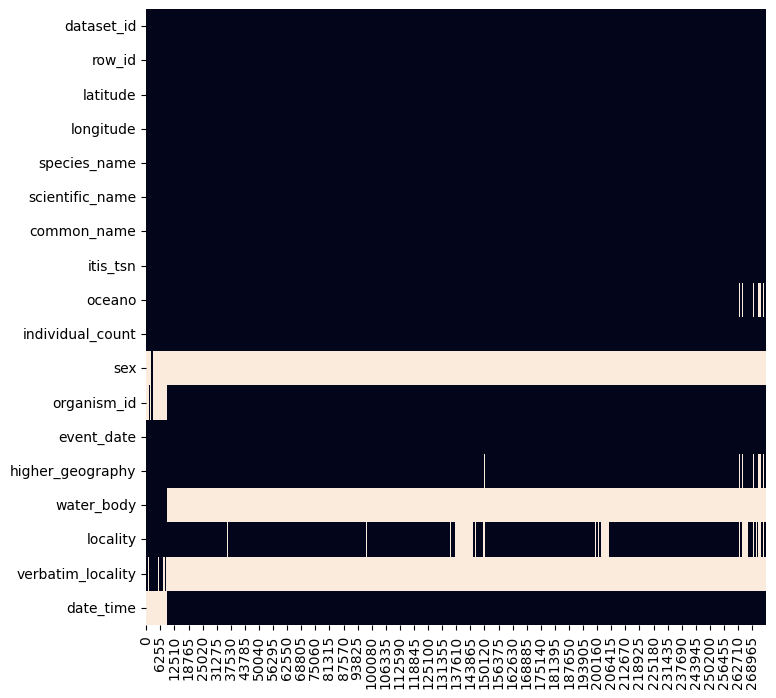

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# missing values quantification
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(df_location.isna().T, cbar=False, yticklabels=True, ax=ax)
plt.show()

<div class="alert alert-block alert-info">

The attributes sex, water_body and verbatim_locality contains a lots of missing values. As we still have the coordinates for all, we could compute the locations info if we need it in the future.

</div>

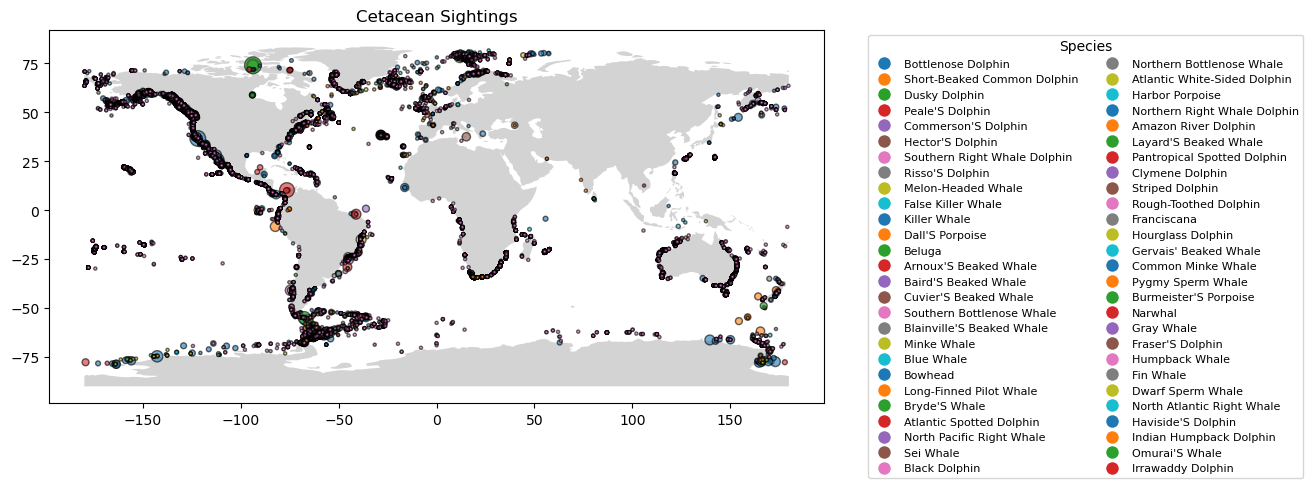

In [5]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import matplotlib.colors as mcolors
from utils import parse_individual_count

# Visualization of sightings locations

geometry = [Point(xy) for xy in zip(df_location['longitude'], df_location['latitude'])]
gdf = GeoDataFrame(df_location, geometry=geometry)   

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color="lightgrey")

marker_size = gdf['individual_count'].fillna(1)
marker_size = marker_size**0.5 * 5 

species_list = gdf['species_name'].unique()
colors = list(mcolors.TABLEAU_COLORS.values())  # Get a list of Tableau colors
species_colors = {species: colors[i % len(colors)] for i, species in enumerate(species_list)}

gdf['color'] = gdf['species_name'].map(species_colors)  # Map species to colors
gdf.plot(ax=ax, marker='o', color=gdf['color'], markersize=marker_size, alpha=0.6, edgecolor='black')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in list(species_colors.values())]
labels = species_list
ax.legend(handles, labels, title="Species", loc="upper left", fontsize=8, bbox_to_anchor=(1.05, 1), ncol=2)

plt.title("Cetacean Sightings")
plt.show()

In [6]:
# We group the species by the proximity of their sightings to improve map readability
LAT_LONG_THRESHOLD = 2
grouped_species = group_species(df_location, LAT_LONG_THRESHOLD)

100%|██████████| 123/123 [00:14<00:00,  8.78it/s]


In [7]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets


geometry = [Point(xy) for xy in zip(grouped_species['longitude'], grouped_species['latitude'])]
gdf = GeoDataFrame(grouped_species, geometry=geometry)

species_list = gdf['species_name'].unique()
# colors =  px.colors.sequential.YlGnBu[2:9] + px.colors.sequential.Greens_r[0:1] + px.colors.sequential.Greens_r[2:5] + px.colors.sequential.OrRd_r[1:9]
colors =  px.colors.sequential.YlOrRd_r  + px.colors.sequential.RdPu[1:] +  px.colors.sequential.Purples_r[:8] + px.colors.sequential.Blues[1:] + px.colors.sequential.Greens_r[:8] + px.colors.sequential.Greys[1:] + px.colors.sequential.Reds_r[1:]
species_colors = {species: colors[i % len(colors)] for i, species in enumerate(species_list)}

gdf['color'] = gdf['species_name'].map(species_colors)

fig = go.Figure()

for species in species_list:
    species_data = gdf[gdf['species_name'] == species]
    fig.add_trace(go.Scattergeo(
        lat=species_data['latitude'],
        lon=species_data['longitude'],
        text=species_data['species_name'],
        marker=dict(
            size=(species_data['individual_count'].fillna(1)*5).clip(lower=5, upper=15), 
            color=species_data['color'], 
            opacity=0.6,
            line=dict(width=1, color='black')
        ),
        name=species, 
        mode='markers'
    ))

fig.update_geos(
    projection_type="mercator",
    showland=True,
    landcolor="lightgrey",
    showlakes=True,
    lakecolor="white"
)

fig.update_layout(
    title="Cetacean Sightings Worldwide: Exploring Species Distribution",
    geo=dict(
        scope='world',
        projection_type='mercator',
        landcolor='lightgrey'
    ),
    legend_title="Species",
    legend=dict(
        itemsizing='constant',
        title='Species',
        x=1.05,
        y=1
    ),
    showlegend=True,
    height=800,
)


fig.show()


C:\Users\camil\AppData\Local\Temp\ipykernel_32212\3978918663.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\camil\AppData\Local\Temp\ipykernel_32212\3978918663.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



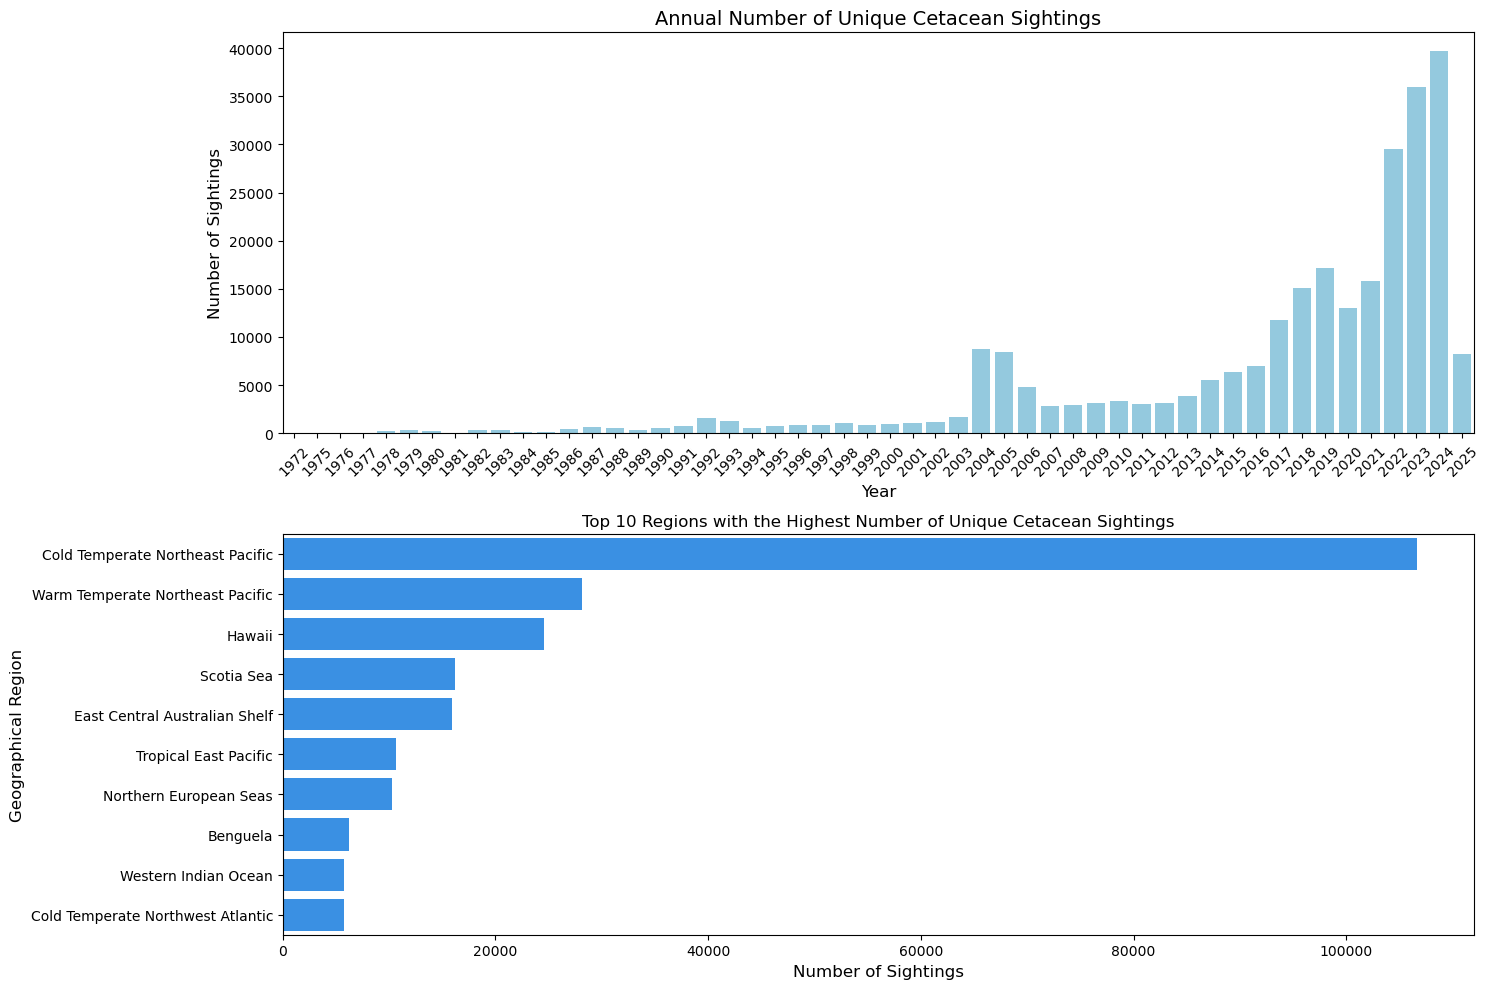

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import extract_unique

df_location_unique = extract_unique(df_location) # extract unique animals

df_location_unique['event_date'] = pd.to_datetime(df_location_unique['event_date'], errors='coerce')
df_location_unique['year'] = df_location_unique['event_date'].dt.year
sightings_per_year = df_location_unique.groupby('year').size().reset_index(name='sightings_count')

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# First subplot: Number of Sighting Events Per Year
sns.barplot(x='year', y='sightings_count', data=sightings_per_year, color='skyblue', ax=axes[0])
axes[0].set_title('Annual Number of Unique Cetacean Sightings', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Sightings', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

# Second subplot: Distribution of Sightings by Higher Geography
df_location_unique = df_location_unique.dropna(subset=['higher_geography'])
sns.countplot(y='higher_geography', data=df_location_unique, order=df_location_unique['higher_geography'].value_counts().index[:10], color='dodgerblue', ax=axes[1])
axes[1].set_title('Top 10 Regions with the Highest Number of Unique Cetacean Sightings', fontsize=12)
axes[1].set_xlabel('Number of Sightings', fontsize=12)
axes[1].set_ylabel('Geographical Region', fontsize=12)

plt.tight_layout()
plt.savefig("figures_EDA/sighting_distribution.png", dpi=400, bbox_inches="tight")
plt.show()


## Multiple Threats: Challenges to Cetacean Survival

### A- Climate disruption

<div class="alert alert-block alert-info">
Large cetaceans migrate thousands of kilometers to feed on krill in high latitudes, but climate change is disrupting these feeding grounds. As prey shifts and productivity declines, their ability to adapt remains uncertain.


Data from <a href="https://marine.copernicus.eu/ocean-climate-portal/sea-surface-temperatures">Copernicus</a> 

Note : An anomaly is the difference from an average value, for example, the anomaly of January 2022 is calculated by the difference between the data value of the month of January in 2022 and the climatology of all the months of January over the time period covered.
</div>

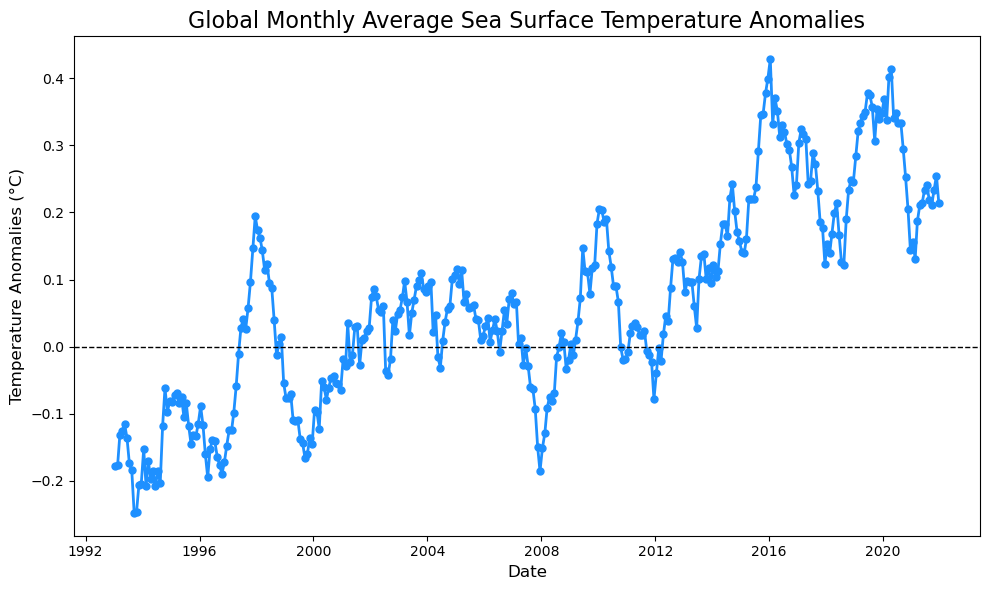

In [13]:
df_temperature = pd.read_csv("data\Copernicus_temperature.csv")
df_temperature['date'] = pd.to_datetime(df_temperature['date'])

plt.figure(figsize=(10, 6))
plt.plot(df_temperature['date'], df_temperature[' - values'], marker='o', color='dodgerblue', linestyle='-', linewidth=2, markersize=5)

plt.title("Global Monthly Average Sea Surface Temperature Anomalies", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature Anomalies (°C)", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("figures_EDA/temperature_anomalies.png", dpi=400, bbox_inches="tight")
plt.show()

### B- Maritime traffic

<div class="alert alert-block alert-info">
Intense maritime traffic increases the risk of ship collisions and adds constant underwater noise, disrupting cetaceans' vital sense of hearing.

Data from IWCShip Strike Database (https://iwc.int/management-and-conservation/ship-strikes)
</div>

In [14]:
df_traffic = pd.read_csv("data\ship_strikes_per_year.csv")
df_traffic.head(3)

,Year,Definite Count,Probable Count,Possible Count
0,1820,1,0,0
1,1954,1,0,0
2,1955,1,0,0


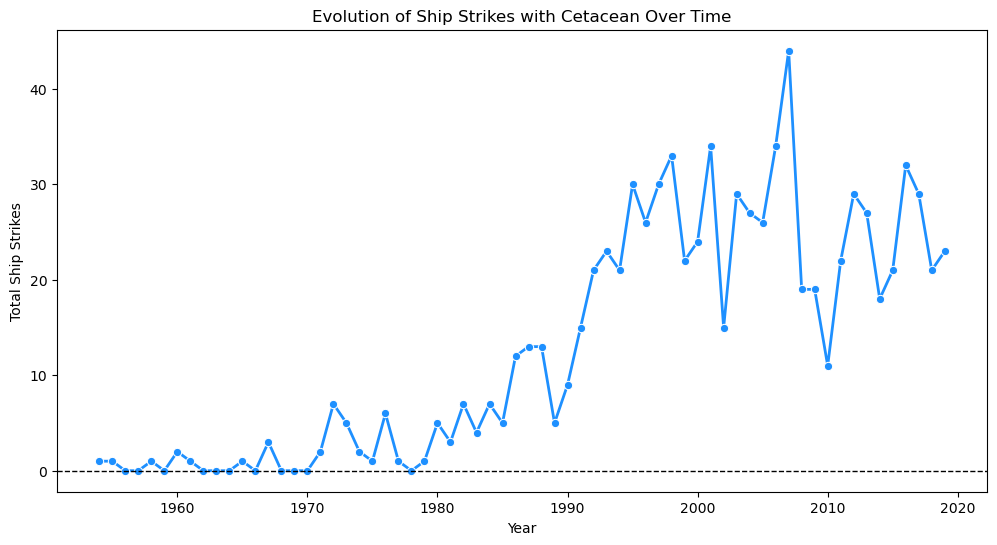

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

df_traffic = df_traffic[pd.to_numeric(df_traffic['Year'], errors='coerce').notna()]
df_traffic['Year'] = df_traffic['Year'].astype(int)
df_traffic= df_traffic[df_traffic['Year']>=1854] # remove the unique outlier at year 1820

df_traffic["Total"] = df_traffic["Definite Count"] + df_traffic["Probable Count"] + df_traffic["Possible Count"]
full_years = pd.DataFrame({'Year': range(df_traffic['Year'].min(), df_traffic['Year'].max() + 1)})
df_traffic = full_years.merge(df_traffic, on='Year', how='left').fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_traffic["Year"], y=df_traffic["Total"], marker="o", color='dodgerblue', linewidth=2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel("Year")
plt.ylabel("Total Ship Strikes")
plt.title("Evolution of Ship Strikes with Cetacean Over Time")
plt.savefig("figures_EDA/traffic_strikes.png", dpi=400, bbox_inches="tight")

plt.show()


### C- Pollution and Plastic contamination

<div class="alert alert-block alert-info">
Chemical pollution has spread across the biosphere, accumulating in the food chain and harming cetaceans' health and fertility. Plastic pollution adds mechanical and chemical threats, entangling marine life and releasing harmful compounds into the ocean.
</div>

### D- Hunting

<div class="alert alert-block alert-info">
Despite a moratorium and the ban on international whaling trade, nearly 1,000 whales are killed annually for commercial purposes. Three countries: Norway, Japan, and Iceland, continue to hunt whales for commercial reasons.


Data from the <a href="https://iwc.int/management-and-conservation/whaling/total-catches">International Whaling Commission</a>

Nb : Type of operation. C: Commercial; A: Aboriginal; I: Illegal;  S: special permit;      -: no catch; Co: Commercial under objection; Cr: Commercial under reservation

</div>

In [28]:
df = pd.read_excel('data\\direct-catches-summary-data-since-1986.xlsx', sheet_name="data", header=0)
df

,Year,Ty,Area,Nation,Fin,Sperm,Humpback,Sei,Brydes,CommonMinke,AntarcticMinke,Gray,Bowhead,Total
0,1986,A,Alaska N,United States,0,0,0,0,0,0,0,2,28,30
1,1986,A,Chukotka,USSR,0,0,0,0,0,0,0,169,0,169
2,1986,A,Greenland E,Denmark/Greenland,0,0,0,0,0,2,0,0,0,2
3,1986,A,Greenland W.,Denmark/Greenland,9,0,0,0,0,145,0,0,0,154
4,1986,A,W. Indies,Saint Vincent & the Grenadines,0,0,2,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,2023,Cr,Iceland W.,Iceland,24,0,0,0,0,0,0,0,0,24
437,2023,I,Greenland E,Denmark/Greenland,0,0,1,0,0,0,0,0,0,1
438,2023,I,Greenland W.,Denmark/Greenland,0,0,0,0,0,1,0,0,0,1
439,2023,I,Korea,Korea,0,0,0,0,0,17,0,0,0,17


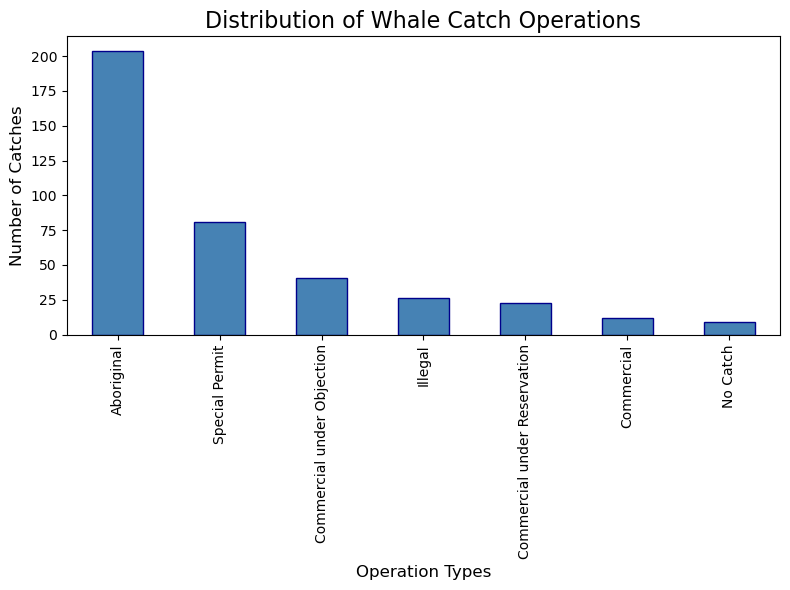

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

type_mapping = {
    'C': 'Commercial',
    'A': 'Aboriginal',
    'I': 'Illegal',
    'S': 'Special Permit',
    '-': 'No Catch',
    'Co': 'Commercial under Objection',
    'Cr': 'Commercial under Reservation'
}

df['Ty_full'] = df['Ty'].map(type_mapping)

operation_counts = df['Ty_full'].value_counts()

plt.figure(figsize=(8, 6))
operation_counts.plot(kind='bar', color='#4682b4', edgecolor='darkblue')

plt.title("Distribution of Whale Catch Operations", fontsize=16)
plt.xlabel("Operation Types", fontsize=12)
plt.ylabel("Number of Catches", fontsize=12)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


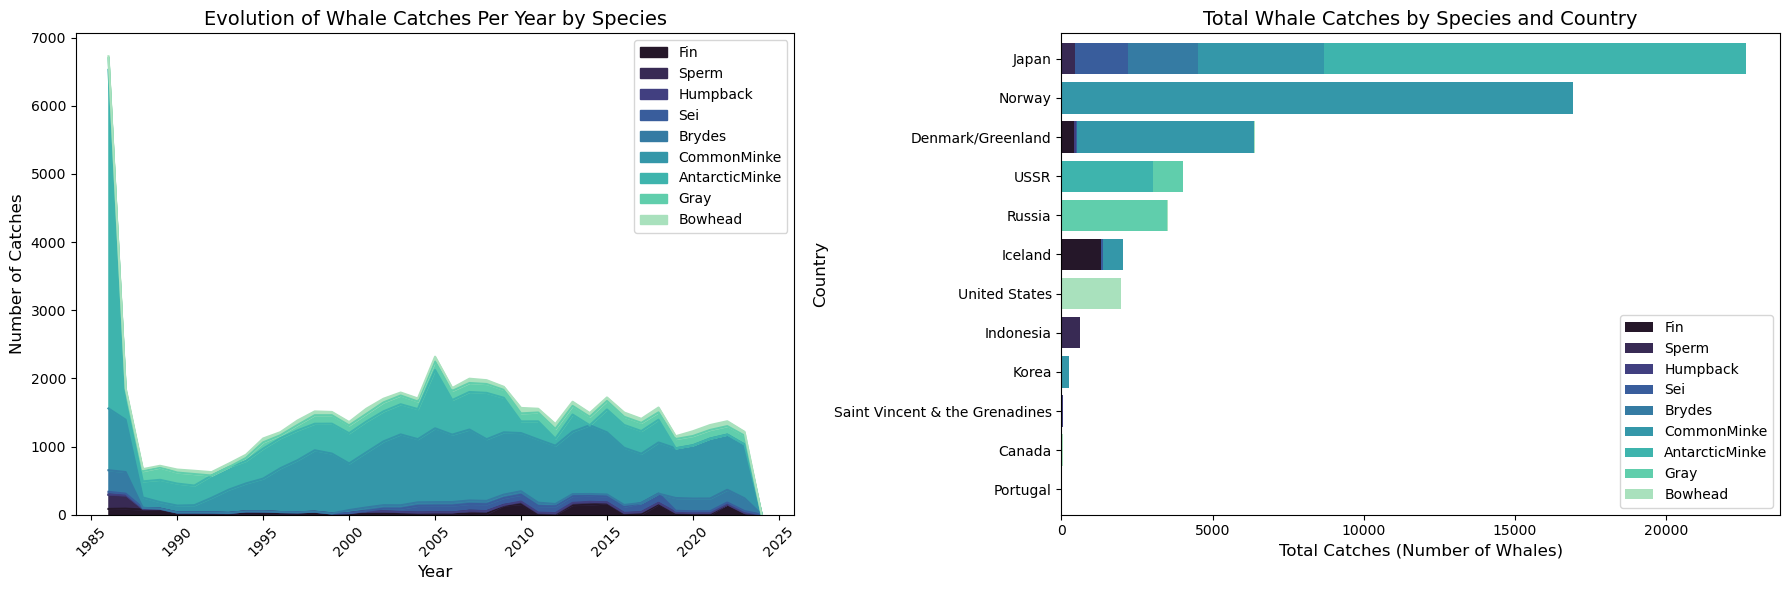

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# First subplot
species_columns = ['Fin', 'Sperm', 'Humpback', 'Sei', 'Brydes', 'CommonMinke', 'AntarcticMinke', 'Gray', 'Bowhead']
palette = sns.color_palette("mako", n_colors=len(species_columns))
df_yearly_catches = df.groupby('Year')[species_columns].sum()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Whale catches per year by species
df_yearly_catches.plot(kind='area', stacked=True, ax=axes[0], color=palette)
axes[0].set_title('Evolution of Whale Catches Per Year by Species', fontsize=14)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Catches', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Second subplot
species_columns = ['Fin', 'Sperm', 'Humpback', 'Sei', 'Brydes', 'CommonMinke', 'AntarcticMinke', 'Gray', 'Bowhead', "Total"]
df_country_catches = df.groupby('Nation')[species_columns].sum()
df_country_catches = df_country_catches.sort_values('Total', ascending=True)
df_country_catches = df_country_catches.drop("Total", axis=1)

# Plot the stacked bar chart using seaborn
df_country_catches.plot(kind='barh', stacked=True, ax=axes[1], color=palette, width=0.8)
axes[1].set_title('Total Whale Catches by Species and Country', fontsize=14)
axes[1].set_xlabel('Total Catches (Number of Whales)', fontsize=12)
axes[1].set_ylabel('Country', fontsize=12)

# Save and show the plots
plt.tight_layout()
plt.savefig("figures_EDA/whale_catches_2plot.png", dpi=400, bbox_inches="tight")
plt.show()


## Solution to protect cetacean: Protected areas

<div class="alert alert-block alert-info">
<img src="data/map.png" alt="Marine Mammal Habitat Map" style="max-width: 1000px; height: auto; border-radius: 5px;">
    <div>
        <p>Explore more about marine mammal habitats at:</p><a href="https://www.marinemammalhabitat.org/">www.marinemammalhabitat.org</a>
    </div>
</div>

In [20]:
df = pd.read_csv("data\INMA.csv")
species_list = ", ".join(df["Qualifying Species"].dropna()) + ", " + ", ".join(df["Supporting Species"].dropna())

def transform_to_list(species_str):
    if isinstance(species_str, str): 
        return [s.strip() for s in species_str.split(".")]  # Strip spaces and split at '.'
    return []  

df["Qualifying Species"] = df["Qualifying Species"].apply(transform_to_list)
df["Supporting Species"] = df["Supporting Species"].apply(transform_to_list)

df


,Area status,Region,Title,Details,Criteria,Qualifying Species,Supporting Species,jurisdiction
0,IMMA,Australia-New Zealand and South East Indian Ocean,Geographe Bay to Eucla Shelf and Coastal Water...,"<a data-content=""Read full IMMA summary"" href=...","A, B2, C1, C2, C3","[Eubalaena australis, Megaptera novaeangliae, ...","[Tursiops aduncus, Delphinus delphis, Balaenop...",Australia
1,IMMA,Australia-New Zealand and South East Indian Ocean,Southern Australian Coastal and Shelf Region IMMA,"<a data-content=""Read full IMMA summary"" href=...","A, B2, C1, C2, C3, D1, D2","[Neophoca cinerea, Arctocephalus forsteri, Eub...","[Megaptera novaeangliae, Balaenoptera borealis...",Austrialia
2,IMMA,Australia-New Zealand and South East Indian Ocean,Southeastern Australian and Tasmanian Shelf Wa...,"<a data-content=""Read full IMMA summary"" href=...","A, B1, B2, C1, C2, C3, D2","[Balaenoptera musculus, Arctocephalus forsteri...","[Delphinus delphis, Tursiops truncatus, Tursio...",Australia
3,IMMA,Australia-New Zealand and South East Indian Ocean,Australian East Coast Migration Corridor IMMA,"<a data-content=""Read full IMMA summary"" href=...","C3, D1","[Megaptera novaeangliae, Balaenoptera acutoros...","[Orcaella heinsohni, Sousa sahulensis, Dugong ...",Australia
4,IMMA,Australia-New Zealand and South East Indian Ocean,Coast and Shelf Waters of Eastern Te Waipounam...,"<a data-content=""Read full IMMA summary"" href=...","A, B1","[Cephalorhynchus hectori, Phocarctos hookeri]","[Megaptera novaeeangliae, Eubalaena australis,...",New Zealand
...,...,...,...,...,...,...,...,...
514,AoI,North West Atlantic Ocean and Wider Caribbean,Golfe de la Gonâve AoI,"<a data-content=""Requires more data"" href=""htt...",Unconfirmed - pending further assessment,[Unconfirmed - pending further assessment],"[Balaenoptera acutorostrata, Globicephala macr...","Haiti, Cuba"
515,AoI,North West Atlantic Ocean and Wider Caribbean,Eastern Caribbean Windward Offshore Waters AoI,"<a data-content=""Requires more data"" href=""htt...",Unconfirmed - pending further assessment,[Unconfirmed - pending further assessment],[Megaptera novaeangliae],"Antigua and Barbuda, Dominica, Barbados, Guade..."
516,AoI,North West Atlantic Ocean and Wider Caribbean,Panama-Costa Rica Manatee Corridor AoI,"<a data-content=""Requires more data"" href=""htt...",Unconfirmed - pending further assessment,[Unconfirmed - pending further assessment],[Trichechus manatus manatus],"Panama, Costa Rica"
517,AoI,North West Atlantic Ocean and Wider Caribbean,Southern Gulf of Mexico Inner Shelf AoI,"<a data-content=""Requires more data"" href=""htt...",Unconfirmed - pending further assessment,[Unconfirmed - pending further assessment],"[Tursiops truncatus, Trichechus manatus manatu...",Mexico


<div class="alert alert-block alert-info">

The World Database on Protected Areas is a comprehensive global database on terrestrial and marine protected areas. (https://www.protectedplanet.net/en/thematic-areas/wdpa?tab=WDPA)

</div>

In [ ]:
import geopandas as gpd
import fiona

gdb_path = "data\\WDPA_Mar2025_Public.gdb"

try:
    layers = fiona.listlayers(gdb_path)
    print("Available Layers:", layers)
except Exception as e:
    print("Error reading GDB:", e)

gdf = gpd.read_file(gdb_path, layer=layers[0])

Available Layers: ['WDPA_poly_Mar2025', 'WDPA_point_Mar2025', 'WDPA_source_Mar2025']


c:\Users\camil\miniconda3\envs\ada\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning:

organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined



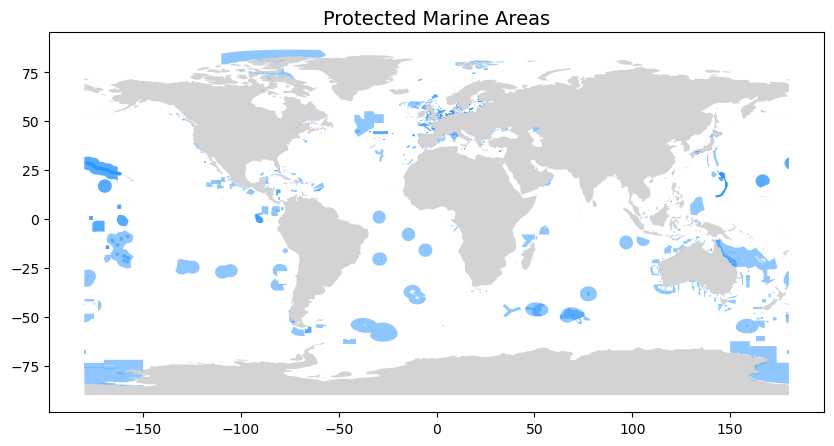

In [ ]:
world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
marine_gdf = gdf[gdf['MARINE'] == "2"]
fig, ax = plt.subplots(figsize=(10, 6))

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
world.plot(ax=ax, color='lightgray')

# Plot the protected areas as MULTIPOLYGON geometries
marine_gdf.plot(ax=ax, color='dodgerblue', alpha=0.5)

ax.set_title('Protected Marine Areas', fontsize=14)
plt.savefig("figures_EDA/protected_areas.png", dpi=400, bbox_inches="tight")

plt.show()